In [34]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%run /Users/davidfitzpatrick/Desktop/Codes/Python_codes/Finance_codes/tools/HRP.ipynb

Functions Used, except HRP which is largely pulled from Marcos Lopez de Prados original Heirachical Risk Parity paper

In [14]:
def import_data(tickers, start, end, give = "R", adj_close = True, dividend = True):#read in stock data  
    """
    tickers: tickers to read 
    start, end: dates in datetime.datetime(2015,12,1) format
    give: return prices or returns 
    adj_close: use adjusted or unadjusted price
    dividend: include dividend?
    
    """
    if give=='D':
        adj_close=False
        dividend = True
    
    stocks = pd.DataFrame()
    if (adj_close == True):
        dividend = False
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Adj Close']
    else:
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Close']
            
        if (dividend == True): 
            stock_div = pd.DataFrame(index=stocks.index)
            for tick in tickers:
                stock_div[tick+' div'] = data.DataReader(tick, 'yahoo-dividends', start, end)["value"]
      
    just_stocks=stocks
    if (dividend == True):
        stocks = pd.concat([stocks,stock_div],axis=1)
        stocks = stocks.fillna(0)
        
    if(give == "R"):
        #Adding dividends to price appreciation on a daily percent return basis -useful for all analysis
        raw_returns=pd.DataFrame()
        for tick in tickers:
            if (dividend == True):
                raw_returns[tick] = stocks[tick].pct_change() + stocks[tick+' div']/stocks[tick] 
                #dividends are actually added on the day before they should be added but this error is neglegible
            else:
                raw_returns[tick] = stocks[tick].pct_change()
        returns=raw_returns[1:]
        return returns[np.isfinite(returns).all(1)]
        
    if(give == "P"):
        return just_stocks
    
    if(give=="D"):
        dividend = pd.DataFrame(np.array(stocks.iloc[:,len(just_stocks.columns):])/np.array(stocks.iloc[:,:len(just_stocks.columns)])).set_index(just_stocks.index)
        dividend.columns=just_stocks.columns
        return dividend
    
    
from pandas.core.common import flatten
#backtest shell function
def backtest(weights, col, dataf, days_between_rebalance, rebalance_func, show_weights=False, wealth = 1, RebalanceOffset=0, give='R',formation = 0): #cols allows users to backtest subsets of dataframe
    """
    weights: tells the function the number of assets. sets the starting weights and is the weights for constant rebalancing
    wealth: sets starting value
    RebalanceOffset: to offset day of rebalances by these values to avoid rebalance timing luck
    give: return returns or prices
    formation: number of days covariance matrix is formed over
    
    """
    colin=[0]*len(weights)
    port=[0]*len(weights)
    worth=[wealth]

    for n in range(len(weights)):
        colin[n] = dataf.columns.get_loc(col[n])
        port[n]=wealth*weights[n]

    for n in range (formation,len(dataf)):
        port = np.multiply(port, np.array((1+dataf.iloc[n,colin])))

        end_of_day = sum(port)
        worth.append(end_of_day)
        
        if ((n + RebalanceOffset)% days_between_rebalance==0):        #rebalance
            port=rebalance_func(dataf, n, formation, port, weights, sum(port))
            if show_weights == True:
                print(np.round(np.array(port/sum(port)),2))
            
                
    if (give=='R'):            
        p_rtn = pd.DataFrame(worth).pct_change()[1:].set_index(dataf.index[formation:])
        return(p_rtn)
    if (give=='P'):
        return(pd.DataFrame(worth[1:]).set_index(dataf.index[formation:]))
    
    
def dollar_growth(returns):
    return ((returns+1).cumprod())

def max_dd(prices):
    cum_returns = (1 + prices).cumprod()
    drawdown =  1 - prices.div(prices.cummax())
    return drawdown.expanding().max().iloc[-1,:]

Read in Data

In [36]:
tickers = ['TRRNX','VFFVX','FDEEX',] # trow price seems to have a good fund #,'VFFVX','FDEEX'    #'VFIFX','FFFHX' for pre 2010
start = datetime(2013,1,1)
end = datetime(2021,12,1)
returns = import_data(tickers,start,end, give ="R",dividend=False)

assets = ['VOO','IEF','VGLT','VGSH','VTIP','TRRNX']
asset_returns = import_data(assets,start,end, give ="R",dividend=False)

Sample portfolios to test equal weight Trowe Price target date fund and self built 60/40 varient portfolios

In [64]:
#having this outside the functions ensures all are for apple to apples comparison
trowe_fraction = .5 # choose faith in trowe vs stock bond risk parity

lev_med_portfolio = ['VOO','IEF','VTIP','TRRNX','VGSH']
Lev_med_duration_weights = np.array([0.38, 0.61 , 0.01])

over_under = ['VOO','IEF','VGLT','VTIP','TRRNX','VGSH']
over_under_weights = np.array([0.43, 0.42, 0.02, 0.13])

six_four = ['VOO','VGLT','VTIP','TRRNX','VGSH']
six_four_unlev_rebalance_weights = np.array([0.60, 0.40,.0])

ivp_port = ['VOO','IEF','VGLT','VTIP','TRRNX']

hrp_port = ['VOO','IEF','VGLT','VTIP','TRRNX']

Rebalance functions that are called during backtest. Includes method to reduce rebalance timing luck and turnover

In [81]:
Lev_med_duration_cash = .0
Lev_med_duration_weights_port = np.append(Lev_med_duration_weights*(1-trowe_fraction),trowe_fraction)
Lev_med_duration_weights_scaled = np.append(((1-Lev_med_duration_cash)/Lev_med_duration_weights_port.sum() * Lev_med_duration_weights_port), Lev_med_duration_cash)

def Lev_med_duration(stocks, n, formation_period, port, weights, total):
    update = np.subtract(np.array(Lev_med_duration_weights_scaled), np.array(port/total))/4   #reduce turnover and rebalance timing luck by only moving towards optimal value
    
    #print(abs(update).sum()/2)                       #print turnover
    new_port = np.add(np.array(port/total),update)    #update portfolio weights
    #print(np.round(new_port,2),n)                       #print weights
    
    return total * new_port

def over_under_rebalance(stocks, n, formation_period, port, weights, total):
    update = np.subtract(np.array(over_under_weights_scaled), np.array(port/total))/4   #reduce turnover and rebalance timing luck by only moving towards optimal value
    new_port = np.add(np.array(port/total),update)    #update portfolio weights
    #print(np.round(new_port,2))
    
    return total * new_port

six_four_unlev_rebalance_cash = .0
six_four_unlev_rebalance_weights_port = np.append(six_four_unlev_rebalance_weights*(1-trowe_fraction),trowe_fraction)
six_four_unlev_rebalance_weights_scaled = np.append(((1-six_four_unlev_rebalance_cash)/six_four_unlev_rebalance_weights_port.sum() * six_four_unlev_rebalance_weights_port), six_four_unlev_rebalance_cash)

def six_four_unlev(stocks, n, formation_period, port, weights, total):
    update = np.subtract(np.array(six_four_unlev_rebalance_weights_scaled), np.array(port/total))/4   #reduce turnover and rebalance timing luck by only moving towards optimal value
    new_port = np.add(np.array(port/total),update)    #update portfolio weights
    
    return total * new_port


def ivp_rebalance(stocks, n, formation_period, port, weights, total):
    cov = stocks[n-formation_period : n - 1].cov() 
    ivp = list(flatten(getIVP(cov).reshape(-1,1)))
    ivp_weights = np.array(ivp)*(1-trowe_fraction)
    ivp_weights[-1] += trowe_fraction    #half IVP half trow price port

    update = np.subtract(ivp_weights, np.array(port/total))/4   #reduce turnover and rebalance timing luck by only moving towards optimal value
    new_port = np.add(np.array(port/total),update)    #update portfolio weights
    return total * new_port


from scipy.spatial.distance import squareform
def hrp_rebalance(stocks, n, formation_period, port, weights, total):
    #hrp recursively bisect and equalize risk budgets at every level of heirarchy
    formation = stocks[n - formation_period : n - 1]
    cov,corr = formation.cov(),formation.corr()     #2) compute correl matrix       
    dist=correlDist(corr)                #3) cluster
    link=sch.linkage(squareform(dist),'single')   
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist()   # recover labels
    hrp=getRecBipart(cov,sortIx) # allocation 
    hrp_weights = np.array(hrp[stocks.columns])*(1-trowe_fraction)
    hrp_weights[-1] += trowe_fraction    #half HRP half trow price port

    #for rebalancing every month (21 business days), uses sorted HRP
    update = np.subtract(hrp_weights, np.array(port/total))/4   #reduce turnover and rebalance timing luck by only moving towards optimal value
    
    #print(abs(update).sum()/2)                       #print turnover
    new_port = np.add(np.array(port/total),update)    #update portfolio weights
    #print(np.round(new_port,2),n)                       #print weights
    return total * new_port

create dataframe of sample portfolios and retirement funds for comparison

In [83]:
rebalance_period = 21
formation = 2*252 

LevMedDur = backtest(Lev_med_duration_weights_scaled, asset_returns[lev_med_portfolio].columns, asset_returns[lev_med_portfolio], days_between_rebalance = rebalance_period, rebalance_func = Lev_med_duration, formation = formation)
Six4 = backtest(six_four_unlev_rebalance_weights_scaled, asset_returns[six_four].columns, asset_returns[six_four], days_between_rebalance = rebalance_period, rebalance_func = six_four_unlev, formation = formation)

overlevered_underlevered = backtest(over_under_weights_scaled, asset_returns[over_under].columns, asset_returns[over_under], days_between_rebalance = rebalance_period, rebalance_func = over_under_rebalance, formation = formation)

ivp = backtest(np.ones([len(ivp_port)])/len(ivp_port), asset_returns[ivp_port].columns, asset_returns[ivp_port], days_between_rebalance = rebalance_period, rebalance_func = ivp_rebalance, formation = formation)
hrp = backtest(np.ones([len(hrp_port)])/len(hrp_port), asset_returns[hrp_port].columns, asset_returns[hrp_port], days_between_rebalance = rebalance_period, rebalance_func = hrp_rebalance, formation = formation)





ports = pd.concat([ LevMedDur, overlevered_underlevered, ivp, hrp, Six4],axis=1) #
ports.columns = [ 'LevMedDur', 'overlevered_underlevered','IVP','HRP','Six4'] #
all_potential_portfolios = pd.concat([ports,returns],axis=1).dropna()#

Visualizations of performance

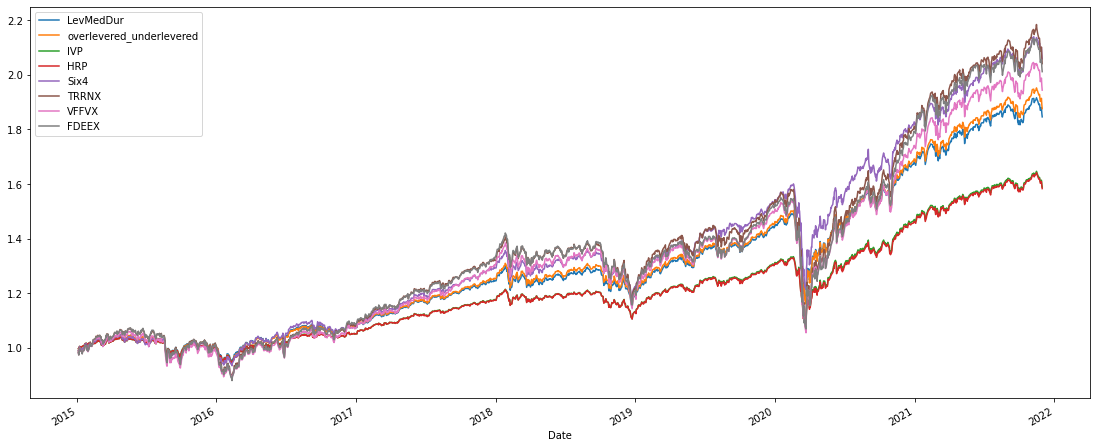

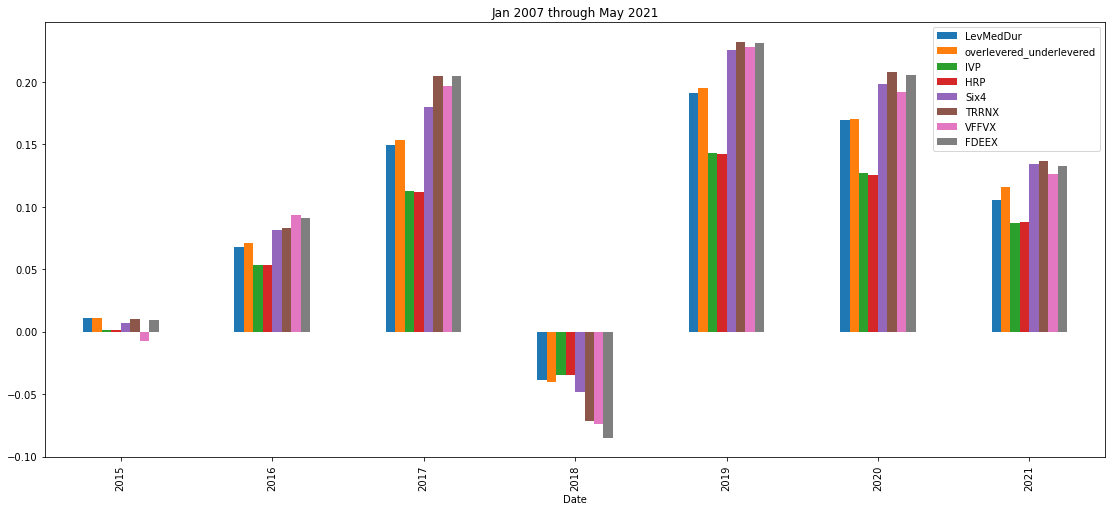

In [84]:
dollar_growth(all_potential_portfolios).plot(figsize=(19,8))
plt.show()

(all_potential_portfolios.groupby([all_potential_portfolios.index.year]).mean()*252).plot(kind='bar',figsize=(19,8)) #all_potential_portfolios.index.month
plt.title("Jan 2007 through May 2021")
plt.show()

metrics of performance

In [85]:
annual_returns = all_potential_portfolios.resample("W").apply(lambda x: ((x + 1).cumprod()-1).last("D"))
geo_mean_annual_return = annual_returns.mean()*52-(np.sqrt(52)*all_potential_portfolios.std())**2/2 #geometric mean
std_annual_return = annual_returns.std()*np.sqrt(52)
drawdown =  max_dd(dollar_growth(all_potential_portfolios)).rename("max drawdown")
(pd.DataFrame([ geo_mean_annual_return, std_annual_return, geo_mean_annual_return/std_annual_return, annual_returns.skew(), drawdown]).T
              .rename(columns ={'Unnamed 0':"geo mean",'Unnamed 1':"std",'Unnamed 3':"skew","Unnamed 2":"geo mean/std"}))

,geo mean,std,geo mean/std,skew,max drawdown
LevMedDur,0.092675,0.102952,0.900174,-0.862712,0.213875
overlevered_underlevered,0.095434,0.108158,0.882362,-0.889974,0.228000
IVP,0.069317,0.079724,0.869459,-1.066881,0.178114
HRP,0.068806,0.079581,0.864606,-1.082167,0.179358
Six4,0.110098,0.121183,0.908527,-0.835009,0.241345
TRRNX,0.112289,0.152826,0.734752,-0.817010,0.325426
VFFVX,0.104514,0.147996,0.706193,-0.910435,0.313964
FDEEX,0.109855,0.150676,0.729080,-0.857886,0.309979


bootstrap to examine performance in alternate constructions of monthly returns

In [86]:
monthly_returns = all_potential_portfolios.resample("M").apply(lambda x: ((x + 1).cumprod()-1).last("D"))
bootstrap = 20000
matrix = np.ones([bootstrap,len(all_potential_portfolios.columns)])
for n in range(bootstrap):
    matrix[n] = np.array((monthly_returns.sample(12)+1).cumprod().iloc[-1])


geo_rtn = (matrix.mean(axis=0)-1)-matrix.std(axis=0)**2/2
pd.DataFrame([ geo_rtn, matrix.std(axis=0), geo_rtn/matrix.std(axis=0)], index = ["mean", "std","Sharpe"], columns = monthly_returns.columns).T

,mean,std,Sharpe
LevMedDur,0.090708,0.088193,1.028521
overlevered_underlevered,0.093133,0.093705,0.993893
IVP,0.067781,0.069757,0.971676
HRP,0.067251,0.069802,0.963463
Six4,0.107536,0.105467,1.019614
TRRNX,0.105588,0.136508,0.773497
VFFVX,0.098085,0.131657,0.745000
FDEEX,0.103397,0.135947,0.760563
